In [90]:
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, model_selection, tree
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi']=300


scaler = MinMaxScaler()
     
# Classifiers
classifiers = {"Naive \nBayes": GaussianNB(), 
               "Adaptive \nBoosting": AdaBoostClassifier(), 
               "Decision \nTree": DecisionTreeClassifier(), 
               "Random \nForest": RandomForestClassifier(random_state=42),
               "Logistic \nRegression": LogisticRegression()
              }


def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]

        clf_class.fit(X_train,y_train)

        y_prob[test_index] = clf_class.predict_proba(X_test)
    return y_prob



def predict_class(proba, cutoff):
    if proba > cutoff:
        y = 1
    else:
        y = 0
    return y

def evaluation_summary(X,y):
    eval_df = pd.DataFrame()
    acc_, prec_, rec_, f1_, auc_, names = [], [], [], [], [], []
    for name, clf in classifiers.items():
        names.append(name)
        start = timeit.default_timer()

        probs = run_prob_cv(X,y,clf)
        
        fpr, tpr, threshold = metrics.roc_curve(y, probs[:,1])
        
        y_pred = [predict_class(prob, 0.5) for prob in probs[:,1]]
        
        acc_.append(accuracy(y, y_pred))
        prec_.append(precision(y, y_pred))
        rec_.append(recall(y, y_pred))
        f1_.append(f1(y, y_pred))
        
        auc_.append(metrics.auc(fpr, tpr))
        
        stop = timeit.default_timer()
#         print ("Completed {0} in {1} seconds".format(name, (stop-start)))
        
    eval_df['Model'] = names
    eval_df['Accuracy'] = acc_
    eval_df['Precision'] = prec_
    eval_df['Recall'] = rec_
    eval_df['F1'] = f1_
    eval_df['AUC'] = auc_
    
    return eval_df

def accuracy(y_true,y_pred): return metrics.accuracy_score(y_true, y_pred)
def precision(y_true, y_pred): return metrics.precision_score(y_true, y_pred)
def recall(y_true, y_pred): return metrics.recall_score(y_true, y_pred)
def f1(y_true, y_pred): return metrics.f1_score(y_true, y_pred)


data = pd.read_csv('../../Data/chenhao_pairs.csv')

measures_category = {'non-network': list(data.columns[5:-11]),
                     'network': ['deg_ratio'],
                     'all': list(data.columns[5:-11]) + ['deg_ratio'] }

blue, red, green, grey ='#336699', '#9A3334', '#048004', '#AAAAAA'


In [91]:
X = data[measures_category['network']].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = data['outcome'].values # select outcome variable
evaluation_summary(X,y)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Naive \nBayes,0.573,0.562,0.663,0.608,0.577
1,Adaptive \nBoosting,0.604,0.573,0.821,0.675,0.616
2,Decision \nTree,0.598,0.570,0.798,0.665,0.609
3,Random \nForest,0.599,0.570,0.810,0.669,0.614
4,Logistic \nRegression,0.548,0.549,0.540,0.544,0.576


In [92]:
X = data[measures_category['non-network']].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = data['outcome'].values # select outcome variable
evaluation_summary(X,y)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Naive \nBayes,0.566,0.637,0.308,0.416,0.618
1,Adaptive \nBoosting,0.586,0.586,0.585,0.586,0.615
2,Decision \nTree,0.560,0.562,0.542,0.552,0.560
3,Random \nForest,0.600,0.601,0.594,0.597,0.648
4,Logistic \nRegression,0.600,0.601,0.594,0.597,0.643


In [93]:
X = data[measures_category['all']].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = data['outcome'].values # select outcome variable
evaluation_summary(X,y)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Naive \nBayes,0.566,0.637,0.306,0.413,0.625
1,Adaptive \nBoosting,0.623,0.617,0.648,0.632,0.666
2,Decision \nTree,0.564,0.566,0.546,0.556,0.564
3,Random \nForest,0.641,0.640,0.644,0.642,0.701
4,Logistic \nRegression,0.618,0.617,0.620,0.619,0.668


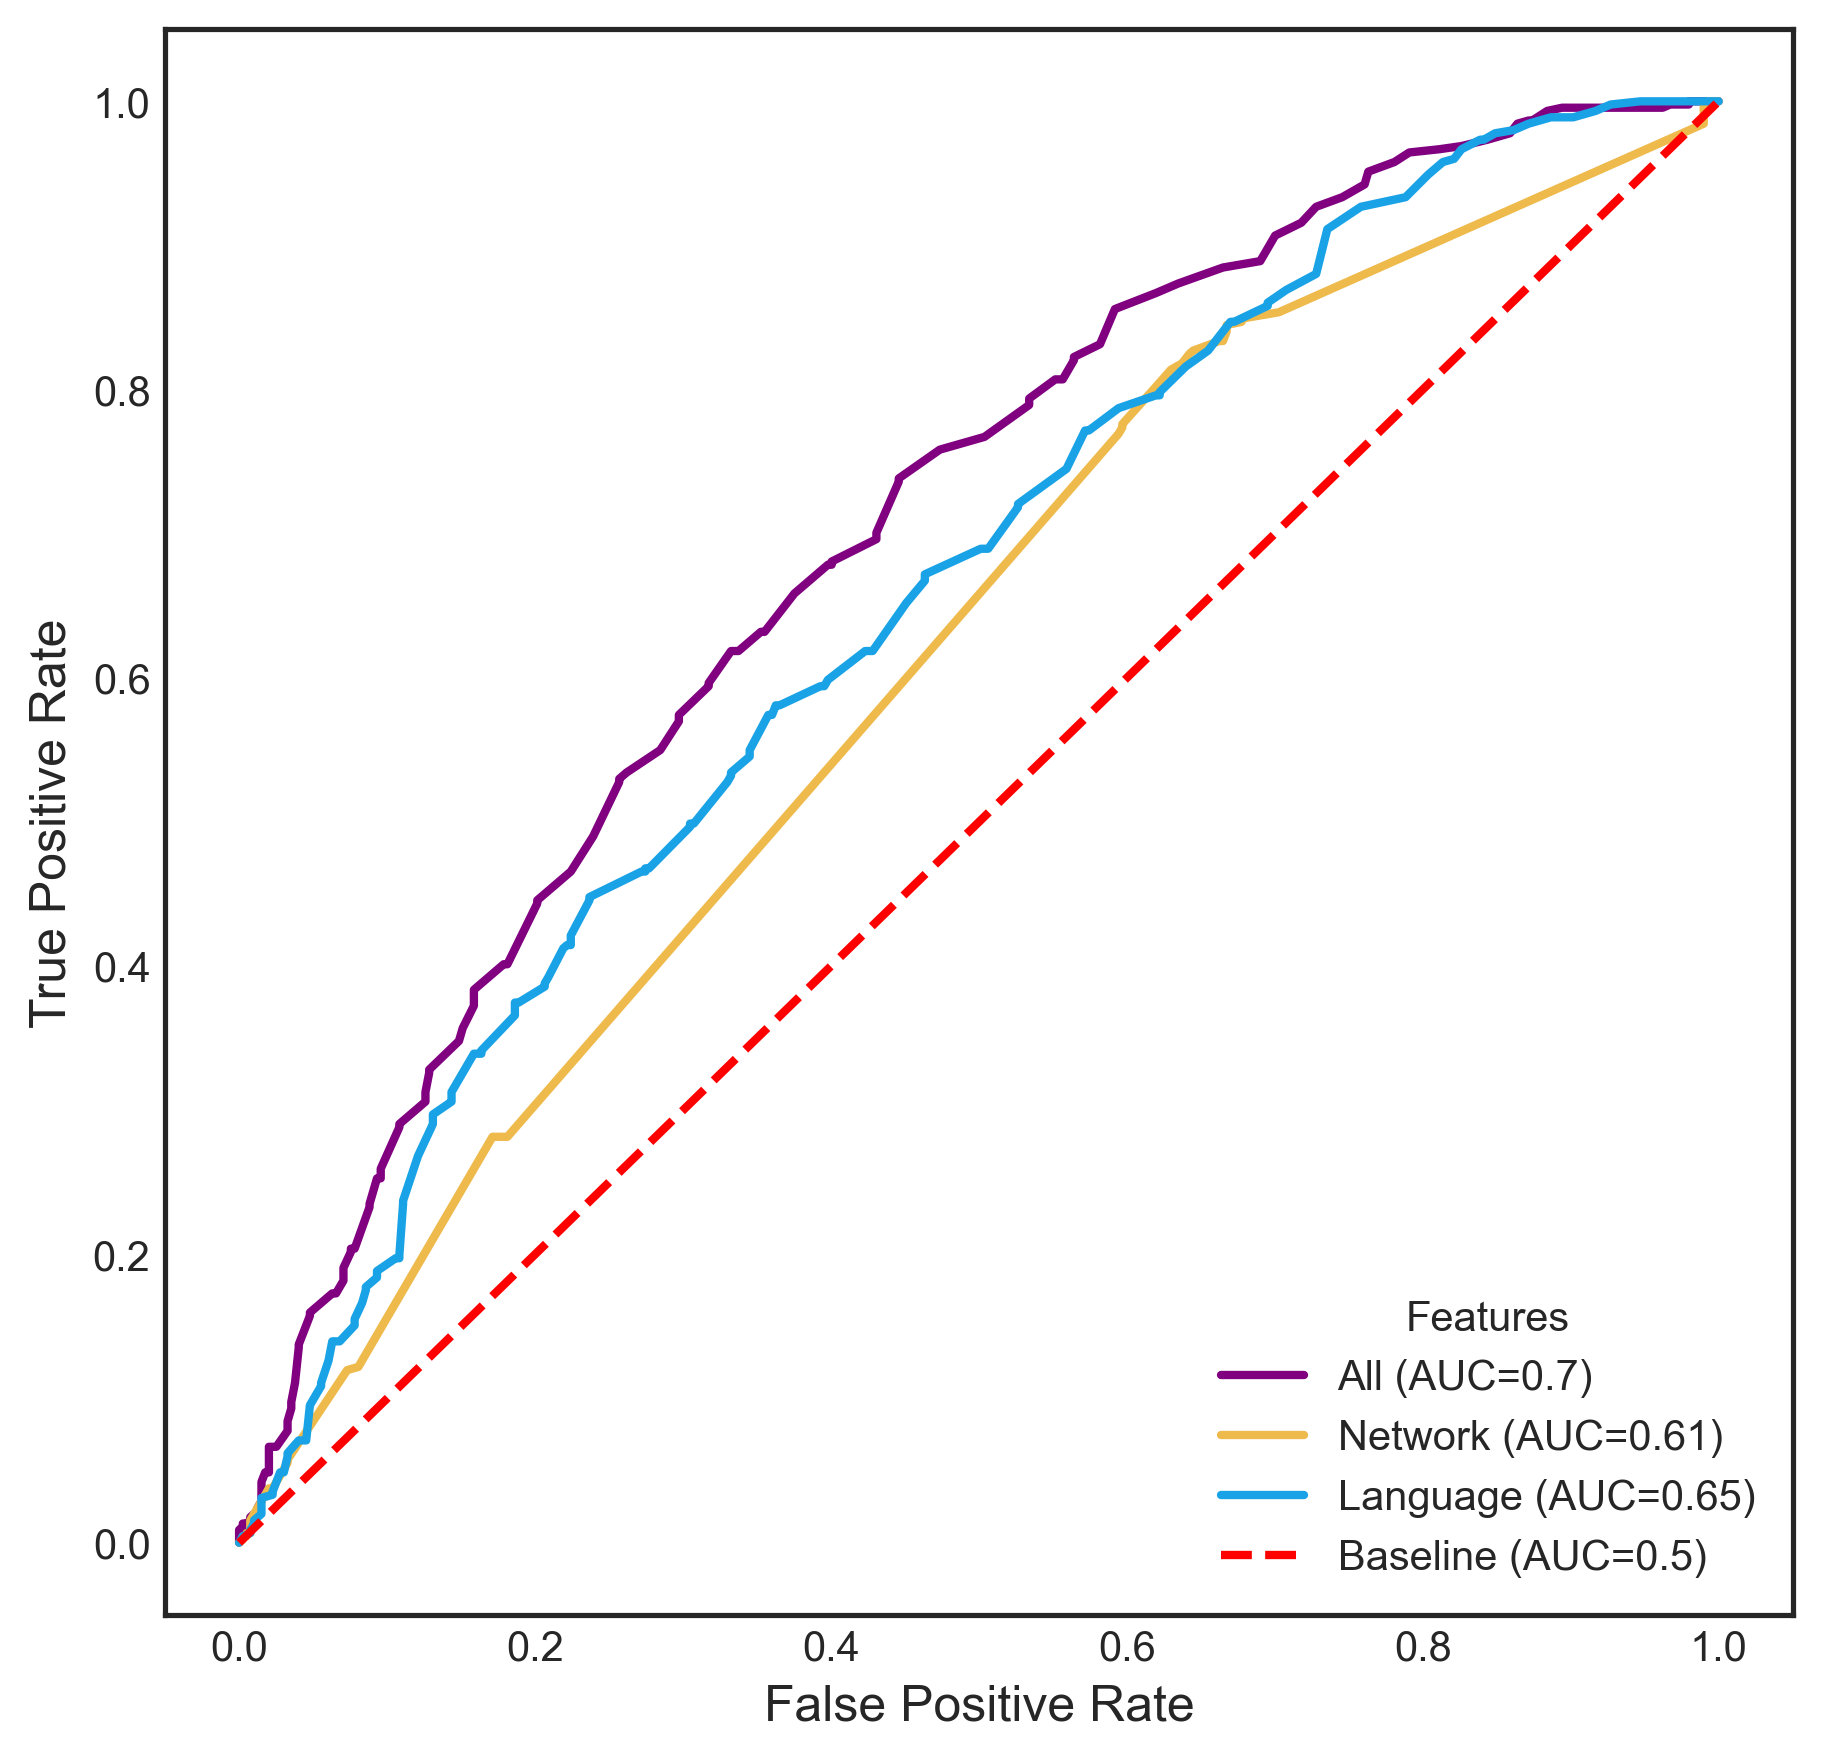

In [23]:
plt.rcParams['figure.dpi']=300
plt.style.use('seaborn-white')

figure = plt.figure(figsize=(7, 7),dpi=300)
s = 10
lw = 2

y = data['outcome'].values

## All Features Plot
X = data[measures_category['all']].to_numpy()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)
# clf = tree.DecisionTreeClassifier(random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc__ = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"All (AUC={str(round(auc__,2))})", linewidth=lw, color="purple")

## Network Features Plot
X = data[measures_category['network']].to_numpy()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc__ = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"Network (AUC={str(round(auc__,2))})", linewidth=lw, color="#EEBA4C")

## Non-NetworkPlot
X = data[measures_category['non-network']].to_numpy()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc__ = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"Language (AUC={str(round(auc__,2))})", linewidth=lw, color='#19A3E6')

x = [0.0, 1.0]
plt.plot(x, x, linestyle='dashed', color='red', linewidth=2, label='Baseline (AUC=0.5)')

plt.xlabel('False Positive Rate', fontsize=s+2)
plt.ylabel('True Positive Rate', fontsize=s+2)
plt.xticks(fontsize=s)
plt.yticks(fontsize=s)

plt.legend(loc="lower right", title='Features', fontsize=10)
plt.show()

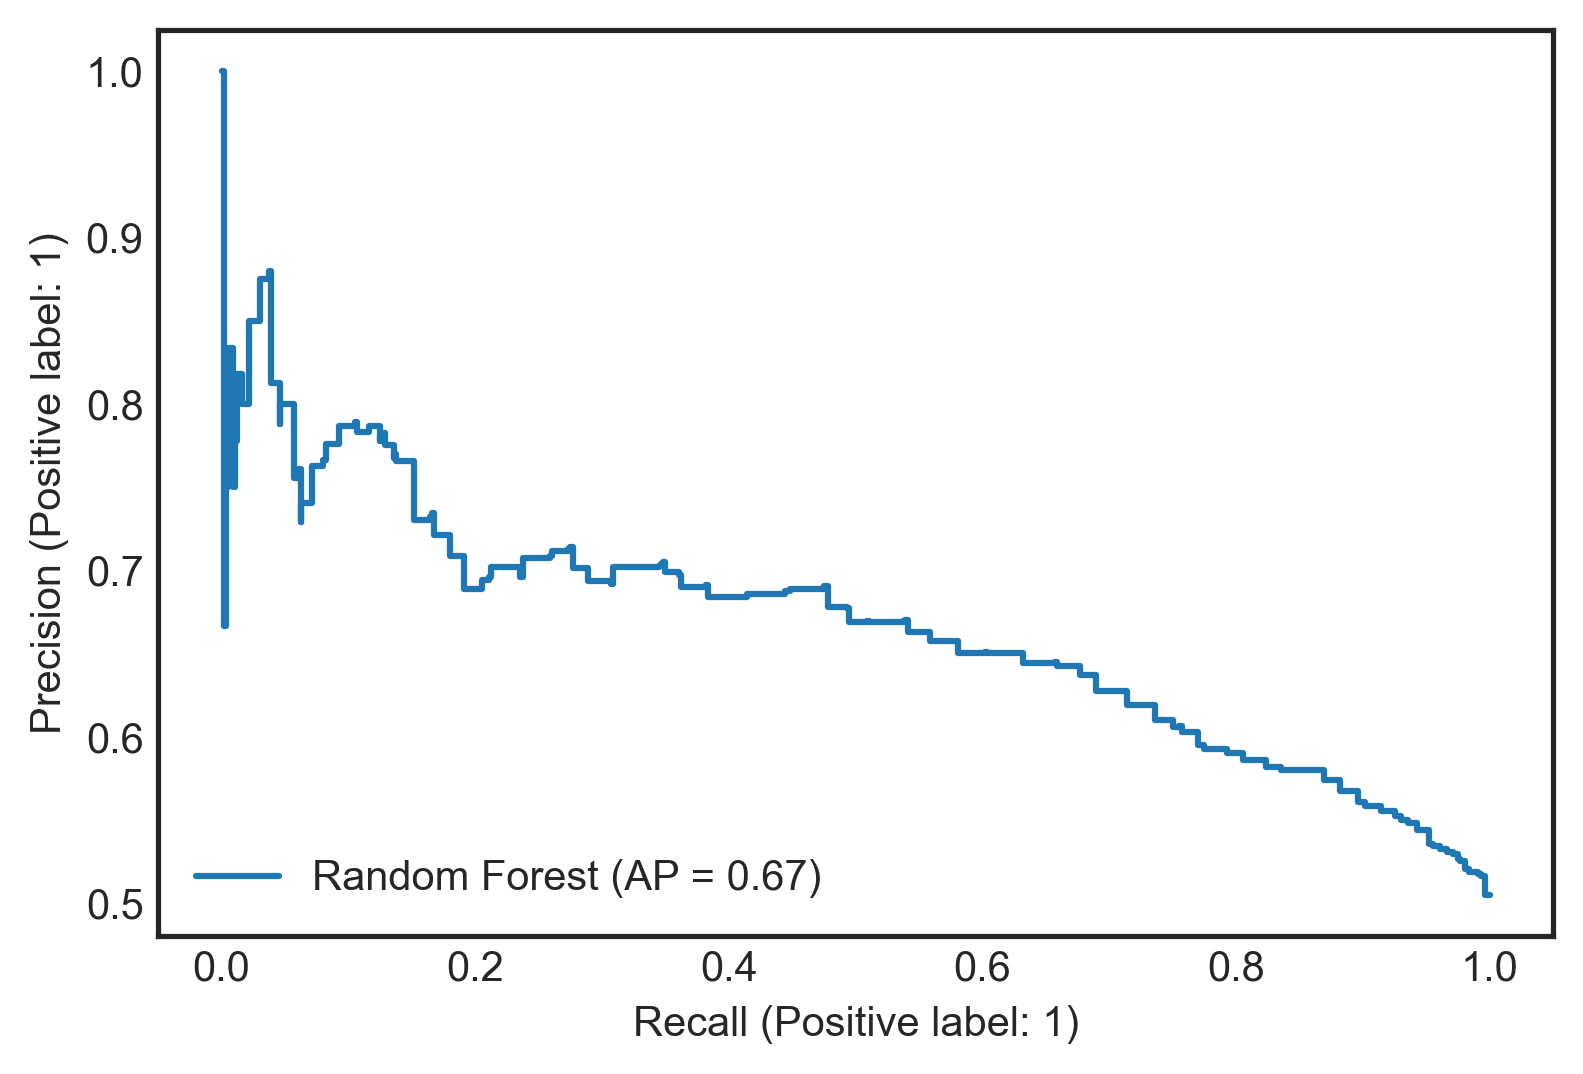

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PrecisionRecallDisplay


classifier = make_pipeline(
    MinMaxScaler(), RandomForestClassifier(random_state=42)
)

X = data[measures_category['all']].to_numpy()
y = data['outcome'].values # select outcome variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

classifier.fit(X_train, y_train)


display = PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test, name="Random Forest");
display.figure_.set_dpi(300)
display.figure_.frameon=True

